# Notas de la investigación de GO3 N.° 1



## Introducción
En Septiembre del año 2025, presentó una nueva publicación sobre un paquete _Python_ que por medio de una optimización por _Rust_ puede calcular varías métricas semánticas asociadas a la información biológica presentada por _Gene Ontology (GO)_. A modo de apunte, me he dedicado a estudiar este paquete durante un período de tiempo con la finalidad de comprender cada uno de sus componentes.

El presente documento se presenta como un cuaderno en Google Colab con la finalidad de no solo ser un medio colaborativo, sino que también interactivo e iterable para ser actualizado durante el tiempo.

In [1]:
%%time
%pip install go3
%pip install goatools
%pip install rpy2
%pip install ipytest

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.
CPU times: total: 78.1 ms
Wall time: 20.6 s



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
%%time
# Invocación de herramientas
import go3                                          # Paquete de cálculo semántico de genes (propuesto).
import goatools                                     # Paquete de cálculo semántico de genes (comparativo).
import pytest                                       # Interfaz de pruebas unitarias.
import math                                         # Módulo de fórmulas o funciones matemáticas nativa de Python.
import seaborn as sns                               # Visualización estadistica
import time                                         # Registro de marcas de tiempo.
import matplotlib.pyplot as plt                     # Gráficos interactivos y visualizables.
import numpy as np                                  # Uso de estructuras numéricas eficientes.
import rpy2                                         # Integración de código/elementos de R.
import ipytest                                      # Pruebas unitarias en cuaderno.
from psutil import *                                # Especificaciones del equipo.
from goatools.obo_parser import GODag               # DAG de términos GO.
from goatools.base import get_godag                 # Carga del DAG de gene ontology.
from goatools.semantic import TermCounts            # Calcula y almacena la frecuencia de términos GO (Gene Ontology).
from goatools.semantic import resnik_sim            # Similitud semántica de Resnik entre dos términos GO.
from goatools.semantic import lin_sim               # Similitud semántica de Lin entre dos términos GO.
from goatools.associations import dnld_assc         # Descarga automáticamente archivos de asociaciones gen–GO.
from goatools.gosubdag.gosubdag import GoSubDag     # Creación de subgrafos de GO.
import random                                       # Generación de valores al azar.
from goatools.semsim.termwise.wang import SsWang    # Calculo de índice de WANG.
from collections import defaultdict                 # Automatización en elementos de construcción de diccionarios.

# Especificaciones de CPU.
print("Numero de cores: ", cpu_count())

# Configuraciones.
ipytest.autoconfig()

Numero de cores:  12
CPU times: total: 15.6 ms
Wall time: 0 ns


En caso de necesitarlo, puede realizar una primera revisión al articulo presente en bioRxiv que esta en el [vínculo](https://www.biorxiv.org/content/10.1101/2025.09.04.669468v1.full.pdf) que fue revisado el día 17-11-2025.

Por otro lado, dentro de este mismo articulo se desglozan otros dos recursos que serían: [Documentación](https://go3.readthedocs.io/en/latest/introduction.html) y [Github](https://github.com/Mellandd/GO3) los cuales fueron revisados el mismo día ya especificado.

Respecto a este documento, se tiene como objetivo recolectar todos los elementos necesarios para realizar una revisión detallada de los experimentos realizados por los autores.

## Pruebas unitarias existentes.

En esta sección se repasan los _scripts_ que existen en el _Github_.

In [10]:
%%time

# Archivo: test_equality.py
from goatools.obo_parser import GODag     # Única importación con participación.

""" Prueba definida por autor/es """

# Solo se prueba si la cantidad de términos obtenidos con ambos paquetes sea
# el mismo (lectura correcta).
def test_equal_size():
    terms_go3 = {t.id for t in go3.load_go_terms()}
    terms_goatools = {t for t in GODag("go-basic.obo")}
    assert(len(terms_go3) == len(terms_goatools))

""" _____________________________"""

ipytest.run()

go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms
.............                                                                                [100%]

Running teardown with pytest sessionfinish...


13 passed in 159.36s (0:02:39)
CPU times: total: 16min 17s
Wall time: 2min 40s


<ExitCode.OK: 0>

In [11]:
%%time

# Archivo: test_loading.py

""" Pruebas definida por autor/es """

# Prueba de caso usual de carga de términos.
def test_load_go_terms():
    terms = go3.load_go_terms()
    assert isinstance(terms, list)
    assert len(terms) > 10000  # Número típico de términos GO.
    assert any(t.id.startswith("GO:") for t in terms) # Verifica que los id's procesados posean el prefijo "GO:".

# Prueba de carga de DAG.
def test_load_gaf():
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")  # Debe estar descargado (ruta).
    assert isinstance(gaf, list)
    assert len(gaf) > 100000  # Número típico de anotaciones.
    assert hasattr(gaf[0], "db_object_id")  # Verifica si el objeto gaf posee un db_object_id para comprobar su es un grafo con "GO:" id's.
    assert gaf[0].go_term.startswith("GO:")

""" _____________________________"""

ipytest.run()

go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms
.............                                                                                [100%]

Running teardown with pytest sessionfinish...


13 passed in 159.45s (0:02:39)
CPU times: total: 16min 5s
Wall time: 2min 40s


<ExitCode.OK: 0>

In [12]:
%%time

# Archivo: test_similarity.py

""" Pruebas definida por autor/es """

# Prueba secuencial de métodos para la definición de similitud entre genes:
"""
Datos adicionales:
Las métricas de similitud disponibles por la librería a partir de la
fecha 15/12/2025 son:

  - resink -          Se basa en la métrica information content (IC) que determina que
                      dos términos son similares según el término de mayor información
                      que comparten.

  - lin -             Versión normalizada de Resink que considera tanto el ancestro más
                      informativo como la información total entre el par de términos.

  - Jiang–Conrath -   Distancia semántica basada en la información que se pierde o que
                      no comparten ambos terminos.

  - SimRel -          Modificación del calculo de lin basado en la especiación que tiene
                      en ancestro más informativo entre un par de términos.

  - Information
      Coefficient -   Similitud basada directamente en el contenido de información de
                      los términos GO.

  - GraphIC -         Similitud considerando toda la estructura del subgrafo GO,
                      no solo el MICA.

  - Wang -            Similitud topológica, independiente de frecuencias estadísticas.

  - TopoICSim -       Combinación de topología + información.

"""

# Prueba la validez de resultados entre dos implementaciones de las métricas de
# similitud usando dos términos para ejemplo.
def test_similarity_all_methods():
    # Carga de terminos y grafo asociados al ser humano.
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)

    # Términos de prueba y métodos.
    go1 = "GO:0006397"  # mRNA processing
    go2 = "GO:0008380"  # RNA splicing
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]

    # Obtención de ic de cada uno (teniendo en consideración que no sean 0).
    ic1 = go3.term_ic(go1, counter)
    ic2 = go3.term_ic(go2, counter)
    assert ic1 > 0
    assert ic2 > 0

    # Prueba por método verificando que ambas implementaciones de similitudes
    # esten entre los rangos determinados siendo estos entre 0 hasta 1. Además
    # de verificar que sean flotantes.
    for method in methods:
        sim = go3.semantic_similarity(go1, go2, method, counter)
        assert isinstance(sim, float)
        if method in ("lin", "wang", "simrel", "topoicsim"):
            assert 0.0 <= sim <= 1.0 + 1e-9
        else:
            assert sim >= 0.0

# Prueba la validez de resultados entre dos implementaciones de las métricas de
# similitud usando dos pares de términos para ejemplo.
def test_similarity_batch_all_methods():
    # Carga de terminos y grafo asociados al ser humano.
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)

    # Términos de prueba y métodos.
    list1 = ["GO:0006397", "GO:0008380"]
    list2 = ["GO:0008380", "GO:0006397"]
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]

    # Prueba por método verificando que ambas implementaciones de similitudes
    # esten entre los rangos determinados siendo estos entre 0 hasta 1. Además
    # de verificar que sean flotantes.
    for method in methods:
        sims = go3.batch_similarity(list1, list2, method, counter)
        assert len(sims) == 2
        for sim in sims:
            assert isinstance(sim, float)
            if method in ("lin", "wang", "simrel", "topoicsim"):
                assert 0.0 <= sim <= 1.0 + 1e-9
            else:
                assert sim >= 0.0

# Prueba la validez de resultados entre dos implementaciones de las métricas de
# similitud usando dos genes para ejemplo.
def test_compare_genes_all_methods():
    # Carga de terminos y grafo asociados al ser humano.
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)

    # Genes de prueba y métodos.
    gene1, gene2 = "BRCA1", "CASP8"
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]

    # Prueba por método verificando que ambas implementaciones de similitudes
    # esten entre los rangos determinados siendo estos entre 0 hasta 1. Además
    # de verificar que sean flotantes.
    for method in methods:
        sim = go3.compare_genes(gene1, gene2, "BP", method, "bma", counter)
        assert isinstance(sim, float)
        if method in ("lin", "wang", "simrel", "topoicsim"):
            assert 0.0 <= sim <= 1.0 + 1e-9
        else:
            assert sim >= 0.0

# Prueba la validez de resultados entre dos implementaciones de las métricas de
# similitud usando dos pares de términos para ejemplo.
def test_compare_genes_batch_all_methods():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)

    # Genes de prueba y métodos.
    pairs = [("BRCA1", "CASP8"), ("GSDME", "NLRP1")]
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]

    # Prueba por método verificando que ambas implementaciones de similitudes
    # esten entre los rangos determinados siendo estos entre 0 hasta 1. Además
    # de verificar que sean flotantes.
    for method in methods:
        sims = go3.compare_gene_pairs_batch(pairs, "BP", method, "max", counter)
        assert len(sims) == len(pairs)
        for sim in sims:
            assert isinstance(sim, float)
            if method in ("lin", "wang", "simrel", "topoicsim"):
                assert 0.0 <= sim <= 1.0 + 1e-9
            else:
                assert sim >= 0.0

# Verifica que la similitud entre un mismo término sea mayor que con otro distinto.
def test_self_similarity_all_methods():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    go_id = "GO:0006397"
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        self_sim = go3.semantic_similarity(go_id, go_id, method, counter)
        other_sim = go3.semantic_similarity(go_id, "GO:0008380", method, counter)
        assert isinstance(self_sim, float)
        # Self-similarity should be at least as high as similarity to another term
        assert self_sim >= other_sim
        # For normalized methods, should be in [0, 1 + epsilon]
        if method in ("lin", "wang", "simrel", "topoicsim"):
            assert 0.0 <= self_sim <= 1.0 + 1e-9

# Verifica que la similitud sea nula entre términos de distintas ontologías, es decir, no relacionados.
def test_unrelated_terms_similarity():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    go1 = "GO:0006397"  # BP
    go2 = "GO:0003674"  # MF
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        sim = go3.semantic_similarity(go1, go2, method, counter)
        assert sim == 0.0

# Verifica que la similitud sea cero entre términos no asociados.
def test_invalid_terms():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    invalid = "GO:9999999"
    valid = "GO:0006397"
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        sim = go3.semantic_similarity(invalid, valid, method, counter)
        assert sim == 0.0
        sim = go3.semantic_similarity(valid, invalid, method, counter)
        assert sim == 0.0
        sim = go3.semantic_similarity(invalid, invalid, method, counter)
        assert sim == 0.0

# Verifica que la similitud sea similar entre dos implementaciones de funciones,
# ya que puede ser para terminos únicos o listas unitarias.
def test_batch_vs_single_consistency():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    go1 = "GO:0006397"
    go2 = "GO:0008380"
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        single = go3.semantic_similarity(go1, go2, method, counter)
        batch = go3.batch_similarity([go1], [go2], method, counter)[0]
        assert math.isclose(single, batch, rel_tol=1e-9)

# Verifica que la similitud entre un par con gen invalido de error.
def test_gene_not_found():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        with pytest.raises(ValueError):
            go3.compare_genes("FAKEGENE1", "BRCA1", "BP", method, "bma", counter)
        with pytest.raises(ValueError):
            go3.compare_genes("BRCA1", "FAKEGENE2", "BP", method, "bma", counter)
        with pytest.raises(ValueError):
            go3.compare_genes("FAKEGENE1", "FAKEGENE2", "BP", method, "bma", counter)

# Verifica que la similitud calculada entre dos genes sea coherente con las características
# del resultado esperado.
def test_groupwise_strategies():
    _ = go3.load_go_terms()
    gaf = go3.load_gaf(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf")
    counter = go3.build_term_counter(gaf)
    gene1, gene2 = "BRCA1", "CASP8"
    methods = ["resnik", "lin", "jc", "simrel", "iccoef", "graphic", "wang", "topoicsim"]
    for method in methods:
        for groupwise in ["bma", "max"]:
            sim = go3.compare_genes(gene1, gene2, "BP", method, groupwise, counter)
            assert isinstance(sim, float)
            assert sim >= 0.0

""" _____________________________"""

ipytest.run()

go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms
.............                                                                                [100%]

Running teardown with pytest sessionfinish...


13 passed in 160.00s (0:02:39)
CPU times: total: 15min 53s
Wall time: 2min 41s


<ExitCode.OK: 0>

Todas las pruebas muestran que el paquete implementado entrega resultados con características coherentes a lo esperado, es decir, que este provee resultados númericos sobre el calculo de similitud entre términos y genes, no obstante, este presenta muchas preguntas que nacen de la práctica de esta tarea:
   1. ¿Qué tipo de representación se utilizan para la identificación de genes? ¿Cuáles son compatibles y como afectan al resultado?
   2. ¿Sólo es compatible la construcción de los DAG con go-basic.obo y .gaf?
   3. ¿Es compatible con el estudio de similitud entre otras especies?
   4. Existen otros paquetes en R ¿Qué diferencias de velocidad y resultados proveen? ¿Son similares?
   5. ¿Existe forma de administrar los identificadores de genes?

## Pruebas de rendimiento (GO3 vs GOATOOLS)

Dentro de esta sección se proveen los 3 códigos de cada prueba de rendimiento realizada y documentada por el equipo desarrollador, esto es con el fin de no solo presentar los resultados dentro de una máquina cualquiera que se puede comprobar, sino finalizar con todas las preocupaciones asociadas a este mismo. La razón de estas preocupaciones es dado a la experiencia de otros paquetes en R que presentan tiempos de computo (especialmente con índice de WANG) que llegan a ser exagerados en máquinas caseras.

C:\Users\benja\Desktop\workspace\GO3_Study\Files\go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms
 GoSubDag: 42666 sources in 42666 GOs rcnt(True). 3312 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()
HMS:0:00:16.908071 972,437 annotations READ: C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf 
34647 IDs in loaded association branch, BP


<timed exec>:54: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
<timed exec>:55: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
D:\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


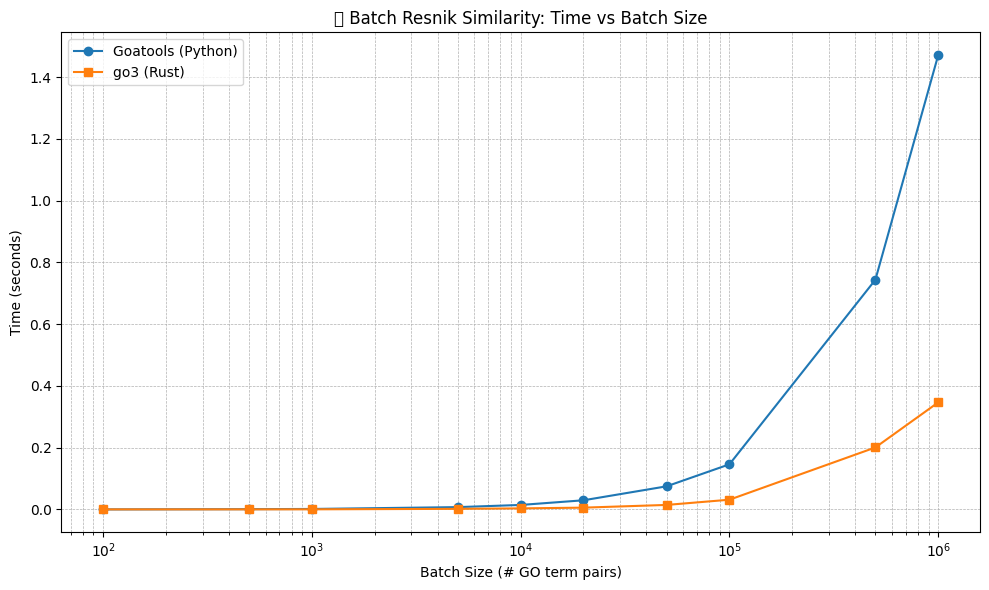

CPU times: total: 38.1 s
Wall time: 27.7 s


In [ ]:
%%time
%matplotlib inline

# PRUEBA DE RENDIMIENTO DE RESNIK (prototipo) -------------------------------
# Esta es una prueba inicial de rendimiento entre los dos paquetes usando la métrica
# RESNIK de forma arbitraria.
# ---------------------------------------------------------------------------

# (1) Setup GO3.
go_terms = go3.load_go_terms()
gaf_path = r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf"
annotations = go3.load_gaf(gaf_path)
counter = go3.build_term_counter(annotations)

# (2) Setup GOATOOLS.
go_dag = GODag(r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\go-basic.obo")
go_subdag = GoSubDag(go_dag.keys(), go_dag)
gene2go = dnld_assc(gaf_path, go_dag)
termcounts = TermCounts(go_dag, gene2go)

# (3) Pares de genes para una prueba justa.
pairs = [("GO:0008150", "GO:0009987"), ("GO:0003674", "GO:0005488")]

# (4) Escenarios de prueba.
batch_sizes = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000, 500000, 1000000]
goatools_times = []
go3_times = []

# (5) Ejecución de todas las pruebas.
for size in batch_sizes:
    test_pairs = pairs * (size // len(pairs))                               # Aumento artificial de pares de términos.

    # Goatools Resnik batch
    start = time.perf_counter()                                             # Inicio de calculo de tiempo.
    _ = [resnik_sim(a, b, go_dag, termcounts) for a, b in test_pairs]       # Cálculo de resnik.
    goatools_times.append(time.perf_counter() - start)                      # Tiempo final.

    # go3 Resnik batch
    start = time.perf_counter()                                             # Inicio de calculo de tiempo.
    _ = go3.batch_similarity([a for a, _ in test_pairs],                    # Cálculo de resnik.
    [b for _, b in test_pairs], 'resnik', counter)
    go3_times.append(time.perf_counter() - start)                           # Tiempo final.

# (6) Creación de gráfico.
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, goatools_times, label="Goatools (Python)", marker='o')
plt.plot(batch_sizes, go3_times, label="go3 (Rust)", marker='s')
plt.xlabel('Batch Size (# GO term pairs)')
plt.ylabel('Time (seconds)')
plt.title('🚀 Batch Resnik Similarity: Time vs Batch Size')
plt.legend()
plt.xscale('log')
#plt.yscale('log')  # Optional: if times grow too much
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("benchmark_batch_evolution.png")
plt.show()

Using matplotlib backend: inline
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms; optional_attrs(relationship)
HMS:0:00:18.277590 972,437 annotations READ: C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf 
34647 IDs in loaded association branch, BP
['A0A024RBG1', 'A0A075B6H5', 'A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1', 'A0A075B6I3', 'A0A075B6I4', 'A0A075B6I6', 'A0A075B6I7', 'A0A075B6I9', 'A0A075B6J1', 'A0A075B6J2', 'A0A075B6J6', 'A0A075B6J9', 'A0A075B6K0', 'A0A075B6K2', 'A0A075B6K4', 'A0A075B6K5', 'A0A075B6K6', 'A0A075B6L2', 'A0A075B6L6', 'A0A075B6N1', 'A0A075B6N2', 'A0A075B6N3', 'A0A075B6N4', 'A0A075B6P5', 'A0A075B6Q5', 'A0A075B6R0', 'A0A075B6R2', 'A0A075B6R9', 'A0A075B6S0', 'A0A075B6S2', 'A0A075B6S4', 'A0A075B6S5', 'A0A075B6S6', 'A0A075B6S9', 'A0A075B6T6', 'A0A075B6T7', 'A0A075B6T8', 'A0A075B6U4', 'A0A075B6U6', 'A0A075B6V5', 'A0A075B6W5', 'A0A075B6X5', 'A0A075B6Y3', 'A0A075B6Y9', 'A0A075B700', 'A0A075B706', 'A0A075B7

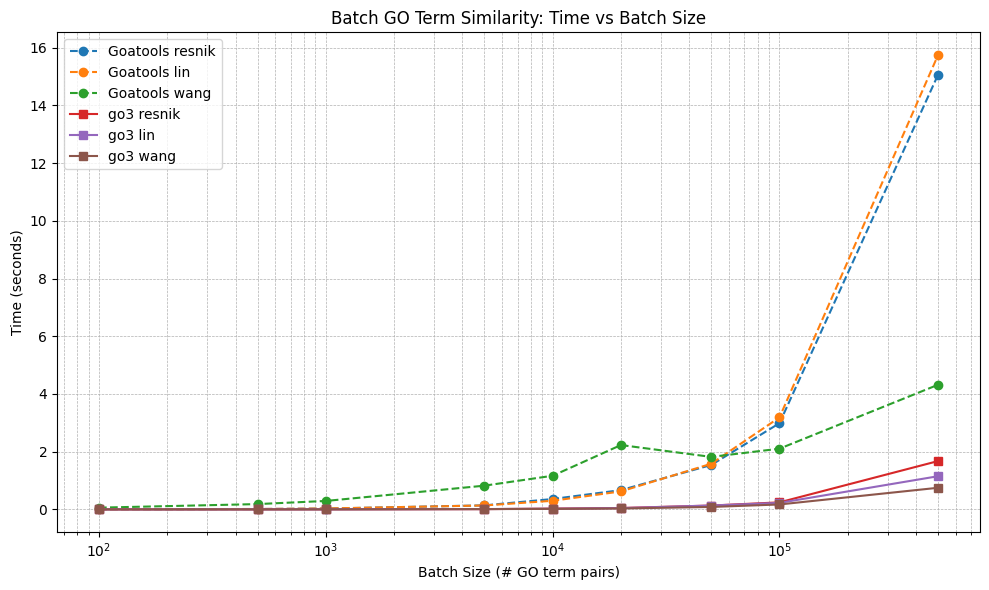

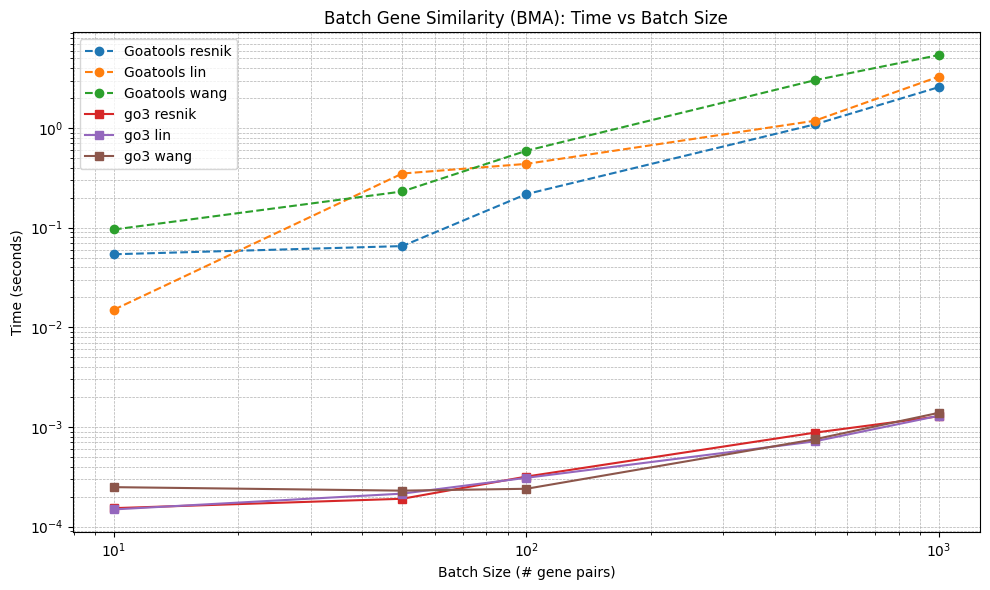

CPU times: total: 2min 18s
Wall time: 1min 51s


In [ ]:
%%time
%matplotlib

# PRUEBA DE RENDIMIENTO  ----------------------------------------------------
# Esta es una prueba de la cual se generá el gráfico asociado al paper públicado, el cambio que 
# realicé es dejarlo más ordenado.
# ---------------------------------------------------------------------------

# ---------------------------------------------------- FUNCIONES PROPIAS.

def sample_unique_pairs(go_ids, n_pairs):
    """
    Se extraen de un conjunto de términos, una muestra de n posibles pares únicos.
    """
    pairs = set()
    while len(pairs) < n_pairs:
        a, b = random.sample(go_ids, 2)
        if a != b:
            pairs.add((a, b))
    return list(pairs)

def goatools_wang(a, b):
    """
    Obtención de Wang por goatools.
    """
    return wang.get_sim(a, b)

def sample_unique_gene_pairs(genes, n_pairs):
    """
    Extracción de un conjunto de pares de genes únicos como muestra de un conjunto
    más grande.
    """
    pairs = set()
    while len(pairs) < n_pairs:
        a, b = random.sample(genes, 2)
        if a != b:
            pairs.add((a, b))
    return list(pairs)

def bma_groupwise(go_terms1, go_terms2, sim_func):
    """
    Criterio BMA para la similitud.
    """
    if not go_terms1 or not go_terms2:
        return 0.0
    max1 = []
    for a in go_terms1:
        sims = [sim_func(a, b) for b in go_terms2]
        sims = [s for s in sims if s is not None]
        if sims:
            max1.append(max(sims))
    max2 = []
    for b in go_terms2:
        sims = [sim_func(b, a) for a in go_terms1]
        sims = [s for s in sims if s is not None]
        if sims:
            max2.append(max(sims))
    if not max1 and not max2:
        return 0.0
    return (sum(max1) + sum(max2)) / (len(max1) + len(max2))

# Similitudes en GOATOOLS
def goatools_resnik(a, b):
    return resnik_sim(a, b, go_dag, termcounts)
def goatools_lin(a, b):
    return lin_sim(a, b, go_dag, termcounts)
def goatools_wang(a, b):
    return wang.get_sim(a, b)


# ---------------------------------------------------- CONSTRUCCIÓN DE LAS PRUEBAS.


# (1) Setup (términos)
go_terms = go3.load_go_terms()                                                      # GO3
gaf_path = r"C:\Users\benja\Desktop\workspace\GO3_Study\Files\goa_human.gaf"
annotations = go3.load_gaf(gaf_path)
counter = go3.build_term_counter(annotations)

go_dag = get_godag("go-basic.obo", optional_attrs={'relationship'})                 # GOATOOLS
gene2go = dnld_assc(gaf_path, go_dag)
termcounts = TermCounts(go_dag, gene2go)

# (2) Setup (genes).
gene_results = {}
gene2go = go3.load_gaf(gaf_path)  # or however you get a dict: gene -> [GO terms]
# If go3.load_gaf returns a list of annotations, build the mapping:
gene2go_map = defaultdict(list)
for ann in annotations:
    gene2go_map[ann.db_object_id].append(ann.go_term)
genes = list(gene2go_map.keys())
print(genes)

# (3) Escenarios (términos).
bp_terms = [t.id for t in go_terms if t.namespace == "biological_process"]
batch_sizes = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000, 500000]

# (4) Escenarios (genes)
gene_batch_sizes = [10, 50, 100, 500, 1000]
go3_gene_times = []
goatools_gene_times = []


# (5) Métricas de similitud (términos).
methods = [
    ("resnik", lambda a, b: resnik_sim(a, b, go_dag, termcounts), "resnik"),
    ("lin", lambda a, b: lin_sim(a, b, go_dag, termcounts), "lin"),
    ("wang", goatools_wang, "wang"),
    # Add more goatools methods if available, e.g. Wang if you have an implementation
]
go3_methods = ["resnik", "lin", "wang"]  # Add more if implemented in go3


# (6) Métricas de similitud (genes).
sim_funcs = {
    "resnik": goatools_resnik,
    "lin": goatools_lin,
    "wang": goatools_wang,
}



# (7) Ejecución de escenarios en términos.
results = {}
for method, goatools_func, go3_method in methods:
    goatools_times = []
    go3_times = []
    for size in batch_sizes:
        test_pairs = sample_unique_pairs(bp_terms, size)
        list1, list2 = zip(*test_pairs)
        # Goatools
        start = time.perf_counter()
        if method == 'wang':
            all_goids = set([a for a, _ in test_pairs] + [b for _, b in test_pairs])
            wang = SsWang(all_goids, go_dag, {'part_of'})
        _ = [goatools_func(a, b) for a, b in test_pairs]
        goatools_times.append(time.perf_counter() - start)
        # go3
        start = time.perf_counter()
        _ = go3.batch_similarity(list(list1), list(list2), go3_method, counter)
        go3_times.append(time.perf_counter() - start)

    results[method] = (goatools_times, go3_times)

# (8) Ejecución de escenarios en genes.
for sim_name, sim_func in sim_funcs.items():
    go3_gene_times = []
    goatools_gene_times = []
    for size in gene_batch_sizes:
        test_gene_pairs = sample_unique_gene_pairs(genes, size)
        # Goatools BMA
        start = time.perf_counter()
        for g1, g2 in test_gene_pairs:
            terms1 = gene2go_map[g1]
            terms2 = gene2go_map[g2]
            if sim_name == 'wang':
                all_goids = set([a for a in terms1] + [b for b in terms2])
                wang = SsWang(all_goids, go_dag, {'part_of'})
            _ = bma_groupwise(terms1, terms2, sim_func)
        goatools_gene_times.append(time.perf_counter() - start)
        # go3 BMA
        start = time.perf_counter()
        _ = go3.compare_gene_pairs_batch(test_gene_pairs, "BP", sim_name, "bma", counter)
        go3_gene_times.append(time.perf_counter() - start)
    gene_results[sim_name] = (goatools_gene_times, go3_gene_times)



# (9) Gráficos.
# --- Plot term-to-term batch ---
plt.figure(figsize=(10, 6))
for method in results:
    goatools_times, go3_times = results[method]
    plt.plot(batch_sizes, goatools_times, label=f"Goatools {method}", marker='o', linestyle='--')
for method in results:
    goatools_times, go3_times = results[method]
    plt.plot(batch_sizes, go3_times, label=f"go3 {method}", marker='s')
plt.xlabel('Batch Size (# GO term pairs)')
plt.ylabel('Time (seconds)')
plt.title('Batch GO Term Similarity: Time vs Batch Size')
plt.legend()
plt.xscale('log')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("benchmark_batch_similarity.png")
plt.show()

# --- Plot gene-to-gene batch ---
plt.figure(figsize=(10, 6))
for sim_name in sim_funcs:
    goatools_gene_times, go3_gene_times = gene_results[sim_name]
    plt.plot(gene_batch_sizes, goatools_gene_times, label=f"Goatools {sim_name}", marker='o', linestyle='--')
for sim_name in sim_funcs:
    goatools_gene_times, go3_gene_times = gene_results[sim_name]
    plt.plot(gene_batch_sizes, go3_gene_times, label=f"go3 {sim_name}", marker='s')
plt.xlabel('Batch Size (# gene pairs)')
plt.ylabel('Time (seconds)')
plt.title('Batch Gene Similarity (BMA): Time vs Batch Size')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("benchmark_gene_batch_similarity.png")
plt.show()

Dentro de las pruebas se concluyen que los experimentos están dentro de lo estimado y son coherentes con lo que se quiere presentar, por ende, solo queda realizar comparaciones y exploraciones respecto al uso del paquete.